## Table of content and model results



## Imports

In [ ]:
!pip install gensim==3.8.3 --quiet

     |████████████████████████████████| 24.2 MB 1.7 MB/s 


In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.2 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 


In [ ]:
!pip install -U tensorflow-text==2.8.2 --quiet

     |████████████████████████████████| 4.9 MB 3.8 MB/s 


In [ ]:
# misc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(42)

# report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.utils import compute_class_weight

import seaborn as sns

# word2vec
import nltk
import gensim
from nltk.data import find
import tensorflow_text as tf_text

# BERT
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and clean data

In [ ]:
# rename uci data to just data
#data = pd.read_csv("/content/drive/MyDrive/W266: SMS Spam Detection Final Project/data/data_clean_trans.csv")
data = pd.read_csv("/content/drive/MyDrive/W266/data/data_clean_trans.csv")
data

,Unnamed: 0,spam,text,crowd,spanish,language,english
0,0,0,"Go until jurong point, crazy.. Available only ...",0,"Vaya hasta Jurong Point, loco ... disponible s...",en,"Go until jurong point, crazy.. Available only ..."
1,1,0,Ok lar... Joking wif u oni...\n,0,Ok lar ... bromeando wif u oni ...\n,en,Ok lar... Joking wif u oni...\n
2,2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0,Entrada gratuita en 2 una compensación de wkly...,en,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,0,U dun say so early hor... U c already then say...,0,No digo tan temprano hor ... ya c ya digo ...\n,en,U dun say so early hor... U c already then say...
4,4,0,"Nah I don't think he goes to usf, he lives aro...",0,"No, no creo que vaya a la USF, aunque vive por...",en,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...,...,...,...,...
6102,6102,1,You have passed the official certification onl...,1,Ha aprobado la certificación oficial de la aud...,en,You have passed the official certification onl...
6103,6103,1,"Win The Big J@CKP0T Up To 1M PHP! 100 GET 100,...",1,¡Gana la gran j@ckp0t hasta 1 m php! 100 Get 1...,en,"Win The Big J@CKP0T Up To 1M PHP! 100 GET 100,..."
6104,6104,1,"Hi, I'm a Shopee Hiring Manager and I'm curren...",1,"Hola, soy un gerente de contratación de Shopee...",en,"Hi, I'm a Shopee Hiring Manager and I'm curren..."
6105,6105,1,"4 PCS SOLAR LIGHTS FOR ONLY 1,499 !\nPinaka mu...",1,"¡4 PCS Luces solares por solo 1,499!\n¡La mayo...",fil,"4 pcs solar lights for only 1,499!\nMost cheap..."


In [ ]:
data = data.convert_dtypes()
data.dtypes

Unnamed: 0     Int64
spam           Int64
text          string
crowd          Int64
spanish       string
language      string
english       string
dtype: object

## EDA

In [ ]:
sum(data["spam"] == 1)

1280

In [ ]:
sum(data["spam"] == 0)

4827

## Split the data

In [ ]:
X, y = data['english'], data['spam']

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    shuffle=True)


## Class weight

In [ ]:

class_weight = compute_class_weight(class_weight ='balanced',
                                               classes=np.unique(train_y),
                                               y=train_y)
class_weight = dict(zip(np.unique(np.unique(train_y)), class_weight))
class_weight

{0: 0.6314632885211996, 1: 2.4016715830875124}

## Helper functions

In [ ]:
def print_metrics(test_name, y_true, y_pred):
    print('%s: accuracy = %.4f, precision = %.4f, recall = %.4f, f1 = %.4f'
          % (test_name,
             metrics.accuracy_score(y_true, y_pred),
             metrics.precision_score(y_true, y_pred),
             metrics.recall_score(y_true, y_pred),
             metrics.f1_score(y_true, y_pred)))

## Base models

- Word2Vec embeddings
  - CNN
  - LSTM

- BERT embeddings
  - Fully connected network
  - CNN


#### Word2Vec embeddings

In [ ]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [ ]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [ ]:
# creating a Word2Vec embedding
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i



In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_X)
test_tokens = tokenizer.tokenize(test_X)

In [ ]:
train_tokens[0]

<tf.Tensor: shape=(18,), dtype=string, numpy=
array([b"You've", b'won', b'tkts', b'to', b'the', b'EURO2004', b'CUP',
       b'FINAL', b'or', b'\xc2\xa3800', b'CASH,', b'to', b'collect',
       b'CALL', b'09058099801', b'b4190604,', b'POBOX', b'7876150ppm'],
      dtype=object)>

In [ ]:
# TO-DO: make sure this is tuned
MAX_SEQUENCE_LENGTH = 5

In [ ]:
def sents_to_ids(token_list_list, label_list, num_examples=100000000):
    """
    converting a list of strings to a list of lists of word ids
    """
    text_ids = []
    text_labels = []
    example_count = 0
    use_token_list_list = token_list_list[:num_examples]
    for i, token_list in enumerate(use_token_list_list):
        if i < num_examples:
            try:
                example = []
                for token in list(token_list.numpy()):
                    decoded = token.decode('utf-8').replace('.','').replace(',','').replace('!','')
                    try:
                        example.append(vocab_dict[decoded])
                        
                    except:
                        example.append(43981)
                if len(example) >= MAX_SEQUENCE_LENGTH:
                    text_ids.append(example[:MAX_SEQUENCE_LENGTH])
                    text_labels.append(label_list[i])
                    if example_count % 5000 == 0:
                        print('Examples processed: ', example_count)
                    example_count += 1
                else:
                    pass
            except:
                pass

    
    print('Number of examples retained: ', example_count) 
    return (np.array(text_ids),   np.array(text_labels)) 

In [ ]:
# convert to tensor
y_train = tf.convert_to_tensor(list(train_y))
y_test = tf.convert_to_tensor(list(test_y))

In [ ]:
train_input, train_input_labels = sents_to_ids(train_tokens, y_train)
test_input, test_input_labels = sents_to_ids(test_tokens, y_test)

Examples processed:  0
Number of examples retained:  4605
Examples processed:  0
Number of examples retained:  1147


#### CNN

In [ ]:
cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
# Specify model hyperparameters.
epochs = 10
num_filters = [3, 2, 1]
kernel_sizes = [2, 4, 5]
dense_layer_dims = [100, 30]
dropout_rate = 0.5

In [ ]:
cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [ ]:
cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

h = cnn_embeddings

In [ ]:
conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

In [ ]:
h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

In [ ]:
h = keras.layers.Dropout(rate=dropout_rate)(h)

In [ ]:
for dense_layer_dim in dense_layer_dims:  
    h = keras.layers.Dense(dense_layer_dim, activation='relu')(h)

In [ ]:
cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(h)

In [ ]:
cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 5, 300)       13194600    ['input_5[0][0]']                
                                                                                                  
 conv1d_61 (Conv1D)             (None, 4, 3)         1803        ['embedding_4[0][0]']            
                                                                                                  
 conv1d_62 (Conv1D)             (None, 2, 2)         2402        ['embedding_4[0][0]']            
                                                                                           

In [ ]:
cnn_history = cnn_model.fit(train_input,
             np.array(train_input_labels),
             validation_data=(test_input, np.array(test_input_labels)),
             class_weight = class_weight,
             batch_size=32,
             epochs=5
             )

Epoch 1/5
144/144 [==============================] - 2s 7ms/step - loss: 0.6080 - accuracy: 0.7153 - val_loss: 0.4615 - val_accuracy: 0.7742
Epoch 2/5
144/144 [==============================] - 1s 6ms/step - loss: 0.4519 - accuracy: 0.7685 - val_loss: 0.3811 - val_accuracy: 0.8605
Epoch 3/5
144/144 [==============================] - 1s 6ms/step - loss: 0.4076 - accuracy: 0.7824 - val_loss: 0.3293 - val_accuracy: 0.8814
Epoch 4/5
144/144 [==============================] - 1s 5ms/step - loss: 0.3705 - accuracy: 0.8115 - val_loss: 0.3065 - val_accuracy: 0.8901
Epoch 5/5
144/144 [==============================] - 1s 5ms/step - loss: 0.3617 - accuracy: 0.8017 - val_loss: 0.2910 - val_accuracy: 0.8989


##### Train report

In [ ]:
dev_pred = cnn_model.predict(train_input)

In [ ]:
test_pred = cnn_model.predict(test_input)

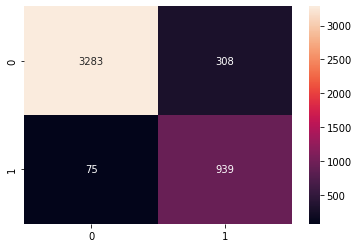

In [ ]:
sns.heatmap(confusion_matrix(np.array(train_input_labels), np.round(dev_pred,0)), annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('W2V + CNN, train data', np.array(train_input_labels), np.round(dev_pred,0))

W2V + CNN, train data: accuracy = 0.9168, precision = 0.7530, recall = 0.9260, f1 = 0.8306


In [ ]:
# TO-DO can't analyze because some texts were discarded during conversion to ids

train_y = train_input_labels
train_y_predict = np.round(dev_pred,0)

##### Test report

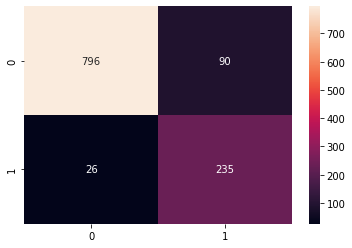

In [ ]:
sns.heatmap(confusion_matrix(np.array(test_input_labels), np.round(test_pred,0)), annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('W2V + CNN, test data', np.array(test_input_labels), np.round(test_pred,0))

W2V + CNN, test data: accuracy = 0.8989, precision = 0.7231, recall = 0.9004, f1 = 0.8020


#### LSTM

In [ ]:
rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1],
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

In [ ]:
def build_classificaiton_rnn_model(rnn_dim):
  """
  max_length:         maximum input length
  rnn_dim:            dimension of the rnn 
  return_sequences:   should the output vectors get returned?  
  return_state:       should the final cell states get returned?
  """
  
  rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

  rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

  # only return the last output from the RNN calculation 
  rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
              (rnn_embeddings)

  rnn_hidden = tf.keras.layers.Dense(100, activation='relu', name='rnn_hidden')(rnn_output)


  rnn_classification = tf.keras.layers.Dense(1, 
                                            activation='sigmoid', 
                                            name='rnn_classification')(rnn_hidden)

  # model definition

  rnn_model = tf.keras.models.Model(inputs=rnn_input_layer, outputs=[rnn_classification])

  rnn_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                  beta_1=0.9,
                                                  beta_2=0.999,
                                                  epsilon=1e-07,
                                                  amsgrad=False,
                                                  name='Adam'),
                  metrics='accuracy')
    
  return rnn_model

In [ ]:
rnn_model = build_classificaiton_rnn_model(rnn_dim=3)

In [ ]:
rnn_history = rnn_model.fit(train_input,
             np.array(train_input_labels),
             validation_data=(test_input, np.array(test_input_labels)),
             class_weight = class_weight,
             batch_size=32,
              epochs=5
             )

Epoch 1/5
144/144 [==============================] - 3s 9ms/step - loss: 0.5952 - accuracy: 0.7731 - val_loss: 0.4048 - val_accuracy: 0.8117
Epoch 2/5
144/144 [==============================] - 1s 5ms/step - loss: 0.3977 - accuracy: 0.8308 - val_loss: 0.3957 - val_accuracy: 0.8317
Epoch 3/5
144/144 [==============================] - 1s 6ms/step - loss: 0.3532 - accuracy: 0.8593 - val_loss: 0.3252 - val_accuracy: 0.8631
Epoch 4/5
144/144 [==============================] - 1s 5ms/step - loss: 0.3303 - accuracy: 0.8738 - val_loss: 0.3368 - val_accuracy: 0.8710
Epoch 5/5
144/144 [==============================] - 1s 5ms/step - loss: 0.3127 - accuracy: 0.8808 - val_loss: 0.2977 - val_accuracy: 0.8797


In [ ]:
dev_pred = rnn_model.predict(train_input)
test_pred = rnn_model.predict(test_input)

##### Train report

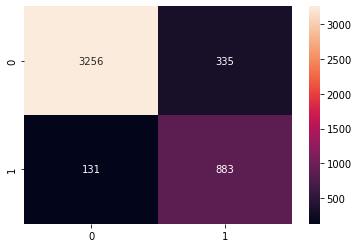

In [ ]:
sns.heatmap(confusion_matrix(np.array(train_input_labels), np.round(dev_pred,0)), annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('W2V + LSTM model, train data: ', np.array(train_input_labels), np.round(dev_pred,0))

W2V + LSTM model, train data: : accuracy = 0.8988, precision = 0.7250, recall = 0.8708, f1 = 0.7912


##### Test report

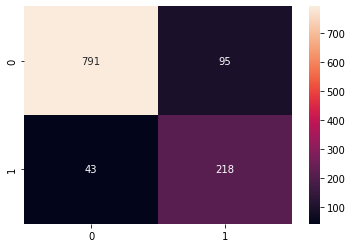

In [ ]:
sns.heatmap(confusion_matrix(np.array(test_input_labels), np.round(test_pred,0)), annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('W2V + LSTM model, test data: ', np.array(test_input_labels), np.round(test_pred,0))

W2V + LSTM model, test data: : accuracy = 0.8797, precision = 0.6965, recall = 0.8352, f1 = 0.7596


#### BERT

In [ ]:
# TO-DO: have to split data again after W2V?
X, y = data['text'], data['spam']

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    shuffle=True)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_length = 100
#max_length = 160                  # set max_length


all_train_examples = list(train_X)
all_test_examples = list(test_X)


x_train = bert_tokenizer(all_train_examples, 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_train = tf.convert_to_tensor(list(train_y))

x_test = bert_tokenizer(all_test_examples, 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_test = tf.convert_to_tensor(list(test_y))

In [ ]:
def create_bert_pooled_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Ouutput for classification purposes
    """

    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # TO-DO: play around with restricting and not restricting BERT layers
    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') #--SOLUTION--
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    ##bert_inputs = {'input_ids': input_ids,
    #              'token_type_ids': token_type_ids,
    #              'attention_mask': attention_mask
    #               }

    #bert_out = bert_model([input_ids, token_type_ids, attention_mask])

    

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 


    
    return classification_model

In [ ]:
pooled_bert_model = create_bert_pooled_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pooled_bert_model_history = pooled_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
                                                  class_weight = class_weight,   
                                                  batch_size=8, 
                                                  epochs=1)  

611/611 [==============================] - 92s 122ms/step - loss: 0.1333 - accuracy: 0.9642 - val_loss: 0.0722 - val_accuracy: 0.9853


In [ ]:
train_predict_labels = pooled_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = train_predict_labels.round(0)

In [ ]:
test_predict_labels = pooled_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

##### Train report

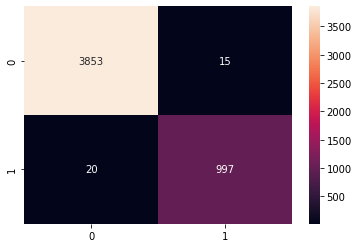

In [ ]:
sns.heatmap(confusion_matrix(np.array(train_y, int), np.array(train_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('BERT + FCN, train data: ', np.array(train_y, int), train_y_predict)

BERT + FCN, train data: : accuracy = 0.9928, precision = 0.9852, recall = 0.9803, f1 = 0.9828


##### Test report

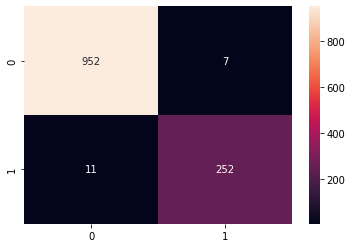

In [ ]:
sns.heatmap(confusion_matrix(np.array(test_y, int), np.array(test_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('BERT + FCN, test data: ', np.array(test_y, int), test_y_predict)

BERT + FCN, test data: : accuracy = 0.9853, precision = 0.9730, recall = 0.9582, f1 = 0.9655


#### BERT Analysis

In [ ]:
train_y_predict = train_y_predict.ravel()

In [ ]:
# spam examples
data['text'][data["spam"] == 1]

2       Free entry in 2 a wkly comp to win FA Cup fina...
5       FreeMsg Hey there darling it's been 3 week's n...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
11      SIX chances to win CASH! From 100 to 20,000 po...
                              ...                        
6102    You have passed the official certification onl...
6103    Win The Big J@CKP0T Up To 1M PHP! 100 GET 100,...
6104    Hi, I'm a Shopee Hiring Manager and I'm curren...
6105    4 PCS SOLAR LIGHTS FOR ONLY 1,499 !
Pinaka mur...
6106    Sissy, 1P lang per bet kay cutt.ly/BingoPlus-P...
Name: text, Length: 1280, dtype: string

In [ ]:
missclassified_text = train_X[train_y != train_y_predict]
missclassified_label = train_y[train_y != train_y_predict]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'missclassified_true_label': missclassified_label})

#df_report['missclassified_true_label'].value_counts()
df_report

,missclassified_text,missclassified_true_label
1612,645,0
2247,Hi ya babe x u 4goten bout me?' scammers getti...,1
1290,Hey...Great deal...Farm tour 9am to 5pm $95/pa...,0
1729,As per your request 'Maangalyam (Alaipayuthe)'...,0
1353,Let Ur Heart Be Ur Compass Ur Mind Ur Map Ur S...,0
5767,Stay a while 'cause somethings always cooking.,1
5687,Huwag sayangin ang boto. Dito na sa sigurado. ...,1
4249,"accordingly. I repeat, just text the word ok o...",1
1766,Hi this is yijue... It's regarding the 3230 te...,0
1407,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...",1


In [ ]:
#train_X[train_y != train_y_predict].loc[1460]

In [ ]:
df_report.loc[2965]

missclassified_text          Do you ever notice that when you're driving, a...
missclassified_true_label                                                    1
Name: 2965, dtype: object

##### Baseline BERT observations
-----------------------------

As expected more text messages that were SPAM got classified as HAM because HAM is the majority class in our dataset.

I looked at a couple examples of texts that got misclassified as HAM and they're tricky to tell if it's a ham or spam messages. The 2 examples contained generic sayings that even a human could mistakenly classify as spam.


*Let Ur Heart Be Ur Compass Ur Mind Ur Map Ur Soul Ur Guide And U Will Never loose in world....gnun - Sent via WAY2SMS.COM*

*1Apple/Day=No Doctor. 1Tulsi Leaf/Day=No Cancer. 1Lemon/Day=No Fat. 1Cup Milk/day=No Bone Problms 3 Litres Watr/Day=No Diseases Snd ths 2 Whom U Care..:-)*


In general the misclassified messages are hard to tell for certain that they are ham or spam.


#### BERT + CNN

In [ ]:
def create_bert_cnn_model(train_layers=-1,
                          hidden_size = 100, 
                          learning_rate=0.00005,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [3, 5, 10, 20],
                          dense_layer_dims = 100,
                          dropout = 0.3):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    ### YOUR CODE HERE

    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # TO-DO: play around with restricting and not restricting BERT layers
    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    # bert_inputs = {'input_ids': input_ids} 
    bert_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[0][:, 1:-1]

    # CNN -----

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(pooled_token)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    #h = keras.layers.Dropout(rate=dropout)(h)

    h = tf.keras.layers.Dense(dense_layer_dims, activation='relu')(h)
    h = tf.keras.layers.Dropout(rate=dropout)(h) 

    # -----

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(h)

    # classification_model = tf.keras.Model(inputs=[input_ids], outputs=[classification])
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy')


    ### END YOUR CODE
    
    return classification_model

In [ ]:
cnn_bert_model = create_bert_cnn_model()

cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            class_weight = class_weight, 
                                            batch_size=8, 
                                            epochs=1)  

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


611/611 [==============================] - 81s 106ms/step - loss: 0.1106 - accuracy: 0.9650 - val_loss: 0.0691 - val_accuracy: 0.9828


In [ ]:
predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = predict_labels.round(0)
test_predict_labels = cnn_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

##### Train report

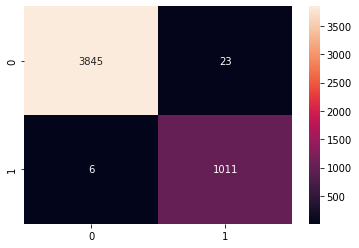

In [ ]:
sns.heatmap(confusion_matrix(np.array(train_y, int), np.array(train_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('BERT + CNN, train data: ', np.array(train_y, int), train_y_predict)

BERT + CNN, train data: : accuracy = 0.9941, precision = 0.9778, recall = 0.9941, f1 = 0.9859


##### Test report

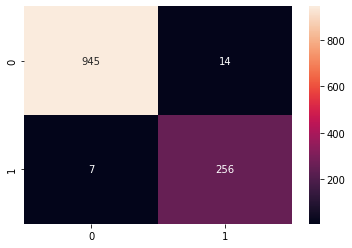

In [ ]:
sns.heatmap(confusion_matrix(np.array(test_y, int), np.array(test_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
print_metrics('BERT + CNN, test data: ', np.array(test_y, int), test_y_predict)

BERT + CNN, test data: : accuracy = 0.9828, precision = 0.9481, recall = 0.9734, f1 = 0.9606


- Train

  - Word2Vec embeddings
    - CNN  |  accuracy = 0.9336, precision = 0.8344, recall = 0.8700, f1 = 0.8519
    - LSTM  |  accuracy = 0.9172, precision = 0.8217, recall = 0.7956, f1 = 0.8085

  - BERT with
    - Fully connected network  |  accuracy = 0.9873, precision = 0.9827, recall = 0.9555, f1 = 0.9689
    - CNN  |  accuracy = 0.9865, precision = 1.0000, recall = 0.9348, f1 = 0.9663

- Test

  - Word2Vec embeddings
    - W2V + CNN, test data: : accuracy = 0.8949, precision = 0.7567, recall = 0.7773, f1 = 0.7669
    - W2V + LSTM model, test data: : accuracy = 0.8897, precision = 0.7452, recall = 0.7656, f1 = 0.7553

  - BERT with
    - BERT + FCN, test data: : accuracy = 0.9885, precision = 0.9841, recall = 0.9611, f1 = 0.9724
    - BERT + CNN, test data: : accuracy = 0.9828, precision = 0.9958, recall = 0.9222, f1 = 0.9576


## Tuned models

#### BERT tuning

**Experiment 1:** Increase the number of epochs because the training kept on improving in the first epoch and we may want to have a couple passes through the model in order to find the most optimal weights for this classification task. Also tune if freezing or unfreezing BERT layers will improve performance. I assume that unfreezing the layers may introduce too many parameters and the model will overfit. But we're expecting the number of epochs to increase performance.

In [ ]:
pooled_bert_model = create_bert_pooled_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pooled_bert_model_history = pooled_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                                  class_weight = class_weight, 
                                                  batch_size=8, 
                                                  epochs=3)  

Epoch 1/3
611/611 [==============================] - 78s 103ms/step - loss: 0.1728 - accuracy: 0.9515 - val_loss: 0.1405 - val_accuracy: 0.9795
Epoch 2/3
611/611 [==============================] - 72s 117ms/step - loss: 0.0841 - accuracy: 0.9861 - val_loss: 0.2200 - val_accuracy: 0.9607
Epoch 3/3
611/611 [==============================] - 59s 96ms/step - loss: 0.1609 - accuracy: 0.9519 - val_loss: 0.1109 - val_accuracy: 0.9771


In [ ]:
train_predict_labels = pooled_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = train_predict_labels.round(0)

In [ ]:
test_predict_labels = pooled_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

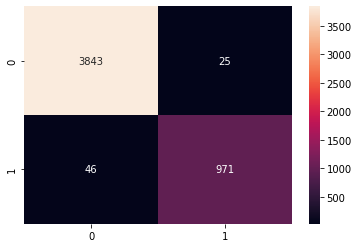

In [ ]:
# train
sns.heatmap(confusion_matrix(np.array(train_y, int), np.array(train_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

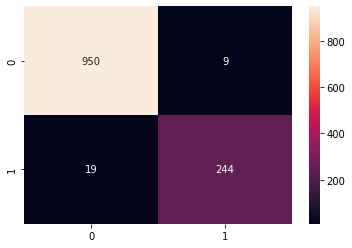

In [ ]:
# test
sns.heatmap(confusion_matrix(np.array(test_y, int), np.array(test_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
# train
print_metrics('BERT 3e + FCN, train data: ', np.array(train_y, int), train_y_predict)

BERT 3e + FCN, train data: : accuracy = 0.9855, precision = 0.9749, recall = 0.9548, f1 = 0.9647


In [ ]:
# test
print_metrics('BERT 3e + FCN, test data: ', np.array(test_y, int), test_y_predict)

BERT 3e + FCN, test data: : accuracy = 0.9771, precision = 0.9644, recall = 0.9278, f1 = 0.9457


In [ ]:
# train
missclassified_text = train_X[train_y != train_y_predict.reshape(-1)]
missclassified_label = train_y[train_y != train_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
3430,I don't know jack shit about anything or i'd s...,0
4111,"Yo, you gonna still be in stock tomorrow/today...",0
4491,My computer just fried the only essential part...,0
856,Talk sexy!! Make new friends or fall in love i...,1
5431,"Er yeah, i will b there at 15:26, sorry! Just ...",0
...,...,...
1235,"""Hello-/@drivby-:0quit edrunk sorry iff pthis ...",0
191,Are you unique enough? Find out from 30th Augu...,1
5797,Globe: You’ve won the Netflix Mug in our Givea...,1
2490,I have 2 docs appointments next week.:/ I'm ti...,0


In [ ]:
# test
missclassified_text = test_X[np.array(test_y, int) != test_y_predict.reshape(-1)]
missclassified_label = test_y[np.array(test_y, int) != test_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
4821,Check Out Choose Your Babe Videos @ sms.shsex....,1
5667,Keep safe and let me assist you to have a CÀSH...,1
5738,Hi! Wànt to àvàil Our Pèrsonàl Loàn? Fàst & eà...,1
2663,Hello darling how are you today? I would love ...,1
913,Can't. I feel nauseous. I'm so pissed. I didn'...,0
1556,Ok i found dis pierre cardin one which looks n...,0
3864,Oh my god! I've found your number again! I'm s...,1
1073,Dear U've been invited to XCHAT. This is our f...,1
263,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0
5615,Did you know that people in cluttered homes ar...,1


**Experiment 1 Results:** As expected increasing number of epochs slightly improved the f1 score and accuracy. Running it on 3 epochs seemed like a good threshold as the loss function kept decresing but the accuracy stopped improving. We're getting pretty good results with only 18 text messages that got missclassfied from the test.

In [ ]:
# unfreeze layers
pooled_bert_model_unfreeze = create_bert_pooled_model(train_layers=1)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pooled_bert_model_history = pooled_bert_model_unfreeze.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                                  class_weight = class_weight, 
                                                  batch_size=8, 
                                                  epochs=3) 

Epoch 1/3
611/611 [==============================] - 43s 59ms/step - loss: 0.1414 - accuracy: 0.9431 - val_loss: 0.0768 - val_accuracy: 0.9795
Epoch 2/3
611/611 [==============================] - 33s 54ms/step - loss: 0.0554 - accuracy: 0.9849 - val_loss: 0.0800 - val_accuracy: 0.9820
Epoch 3/3
611/611 [==============================] - 33s 55ms/step - loss: 0.0346 - accuracy: 0.9914 - val_loss: 0.0501 - val_accuracy: 0.9894


In [ ]:
train_predict_labels = pooled_bert_model_unfreeze.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = train_predict_labels.round(0)

In [ ]:
test_predict_labels = pooled_bert_model_unfreeze.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

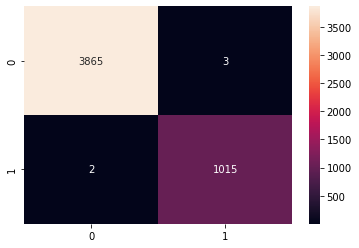

In [ ]:
# train
sns.heatmap(confusion_matrix(np.array(train_y, int), np.array(train_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

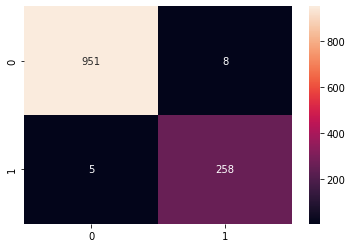

In [ ]:
# test
sns.heatmap(confusion_matrix(np.array(test_y, int), np.array(test_y_predict.reshape(-1), int)), annot=True, fmt='g')  #annot=True to annotate cells, ftm='g' to disable scientific notation

In [ ]:
# train
print_metrics('BERT 3e + FCN, train data: ', np.array(train_y, int), train_y_predict)

BERT 3e + FCN, train data: : accuracy = 0.9990, precision = 0.9971, recall = 0.9980, f1 = 0.9975


In [ ]:
# test
print_metrics('BERT 3e + FCN, test data: ', np.array(test_y, int), test_y_predict)

BERT 3e + FCN, test data: : accuracy = 0.9894, precision = 0.9699, recall = 0.9810, f1 = 0.9754


In [ ]:
# test
missclassified_text = test_X[np.array(test_y, int) != test_y_predict.reshape(-1)]
missclassified_label = test_y[np.array(test_y, int) != test_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
3044,Your bill at 3 is £33.65 so thats not bad!,0
2663,Hello darling how are you today? I would love ...,1
1260,We have sent JD for Customer Service cum Accou...,0
718,Book which lesson? then you msg me... I will c...,0
263,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0
989,Yun ah.the ubi one say if ü wan call by tomorr...,0
5581,N/a,1
2680,"New Tones This week include: 1)McFly-All Ab..,...",1
4330,1Apple/Day=No Doctor. 1Tulsi Leaf/Day=No Cance...,0
925,Actually i deleted my old website..now i m blo...,0


**Experiment 1 Results:** Unfreezing the BERT model layers helped with increasing the F1 score to 0.9745 on running the model for 3 epochs. The performance on the training set was excellent which may mean that we're slightly overfitting. 

Because the performance kept improving we may try to run on a couple more epochs to see if overfitting becomes worse and see if we will hit lower performance on the validation set.

In [ ]:
# unfreeze layers
pooled_bert_model_unfreeze = create_bert_pooled_model(train_layers=1)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# change to 5 epochs
pooled_bert_model_history = pooled_bert_model_unfreeze.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                                  class_weight = class_weight, 
                                                  batch_size=8, 
                                                  epochs=5) 

Epoch 1/5
611/611 [==============================] - 43s 61ms/step - loss: 0.1227 - accuracy: 0.9560 - val_loss: 0.1033 - val_accuracy: 0.9681
Epoch 2/5
611/611 [==============================] - 34s 56ms/step - loss: 0.0483 - accuracy: 0.9859 - val_loss: 0.0495 - val_accuracy: 0.9869
Epoch 3/5
611/611 [==============================] - 34s 55ms/step - loss: 0.0254 - accuracy: 0.9939 - val_loss: 0.0736 - val_accuracy: 0.9836
Epoch 4/5
611/611 [==============================] - 34s 56ms/step - loss: 0.0158 - accuracy: 0.9953 - val_loss: 0.0617 - val_accuracy: 0.9861
Epoch 5/5
611/611 [==============================] - 34s 56ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0668 - val_accuracy: 0.9885


In [ ]:
train_predict_labels = pooled_bert_model_unfreeze.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = train_predict_labels.round(0)

In [ ]:
test_predict_labels = pooled_bert_model_unfreeze.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

In [ ]:
# test
missclassified_text = test_X[np.array(test_y, int) != test_y_predict.reshape(-1)]
missclassified_label = test_y[np.array(test_y, int) != test_y_predict.reshape(-1)]

df_report = pd.DataFrame({'missclassified_text': missclassified_text, 'true_label': missclassified_label})

df_report

,missclassified_text,true_label
3044,Your bill at 3 is £33.65 so thats not bad!,0
5738,Hi! Wànt to àvàil Our Pèrsonàl Loàn? Fàst & eà...,1
2663,Hello darling how are you today? I would love ...,1
714,Save yourself the stress. If the person has a ...,0
718,Book which lesson? then you msg me... I will c...,0
263,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0
989,Yun ah.the ubi one say if ü wan call by tomorr...,0
5581,N/a,1
2680,"New Tones This week include: 1)McFly-All Ab..,...",1
334,Any chance you might have had with me evaporat...,0


In [ ]:
# train
print_metrics('BERT 5e + FCN, train data: ', np.array(train_y, int), train_y_predict)
# test
print_metrics('test data: ', np.array(test_y, int), test_y_predict)

BERT 5e + FCN, train data: : accuracy = 1.0000, precision = 1.0000, recall = 1.0000, f1 = 1.0000
test data: : accuracy = 0.9885, precision = 0.9734, recall = 0.9734, f1 = 0.9734


**Experiment 1 Results:** Increasing the number of epochs to 5 has resulted in some overfitting, we see a degraded performance on the test set in F1 score and increase in the number of misclassified examples. As a result of this experiment BERT model with unfrozen layers and 3 epochs proved to produce really good results. 

Original untuned model test performance:
accuracy = 0.9828, precision = 0.9797, recall = 0.9377, f1 = 0.9583


Tuned model test performance:
accuracy = 0.9893, precision = 0.9841, recall = 0.9650, f1 = 0.9745


#### BERT + CNN tuning

**Experiment 1:** Increase number of epochs and unfreeze BERT layers, not much improvement.

In [ ]:
cnn_bert_model = create_bert_cnn_model(train_layers=1)

cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            class_weight = class_weight, 
                                            batch_size=8, 
                                            epochs=3)  

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
611/611 [==============================] - 47s 66ms/step - loss: 0.0989 - accuracy: 0.9668 - val_loss: 0.0619 - val_accuracy: 0.9836
Epoch 2/3
611/611 [==============================] - 37s 61ms/step - loss: 0.0430 - accuracy: 0.9879 - val_loss: 0.0944 - val_accuracy: 0.9697
Epoch 3/3
611/611 [==============================] - 37s 61ms/step - loss: 0.0194 - accuracy: 0.9943 - val_loss: 0.0558 - val_accuracy: 0.9869


In [ ]:
predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = predict_labels.round(0)
test_predict_labels = cnn_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

In [ ]:
print_metrics('BERT + CNN, train data: ', np.array(train_y, int), train_y_predict)
print_metrics('BERT + CNN, test data: ', np.array(test_y, int), test_y_predict)

BERT + CNN, train data: : accuracy = 0.9977, precision = 0.9903, recall = 0.9990, f1 = 0.9946
BERT + CNN, test data: : accuracy = 0.9869, precision = 0.9625, recall = 0.9772, f1 = 0.9698


**Experiment 2:** Change kernel sizes, from lit review Roy et al. used the following kernel sizes. Kernel sizes improved the model. But now it overfits given that we're running it on 3 epochs.

In [ ]:
cnn_bert_model = create_bert_cnn_model(train_layers=1,
                                       kernel_sizes = [2, 3, 4, 5])

cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            class_weight = class_weight, 
                                            batch_size=8, 
                                            epochs=3)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
611/611 [==============================] - 48s 68ms/step - loss: 0.1088 - accuracy: 0.9648 - val_loss: 0.0470 - val_accuracy: 0.9853
Epoch 2/3
611/611 [==============================] - 37s 61ms/step - loss: 0.0514 - accuracy: 0.9859 - val_loss: 0.0606 - val_accuracy: 0.9804
Epoch 3/3
611/611 [==============================] - 37s 61ms/step - loss: 0.0253 - accuracy: 0.9947 - val_loss: 0.0468 - val_accuracy: 0.9902


In [ ]:
predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = predict_labels.round(0)
test_predict_labels = cnn_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

In [ ]:
print_metrics('BERT + CNN kernel, train data: ', np.array(train_y, int), train_y_predict)
print_metrics('test data: ', np.array(test_y, int), test_y_predict)

BERT + CNN kernel, train data: : accuracy = 0.9996, precision = 1.0000, recall = 0.9980, f1 = 0.9990
test data: : accuracy = 0.9902, precision = 0.9808, recall = 0.9734, f1 = 0.9771


**Experiment 3:** Decrease the number of filters to offset overfitting and possibly increase performance

In [ ]:
cnn_bert_model = create_bert_cnn_model(train_layers=1,
                                       kernel_sizes = [2, 3, 4, 5],
                                       num_filters = [32,64,128])

cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            class_weight = class_weight, 
                                            batch_size=8, 
                                            epochs=3)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
611/611 [==============================] - 47s 66ms/step - loss: 0.1003 - accuracy: 0.9658 - val_loss: 0.0483 - val_accuracy: 0.9861
Epoch 2/3
611/611 [==============================] - 37s 60ms/step - loss: 0.0462 - accuracy: 0.9857 - val_loss: 0.0667 - val_accuracy: 0.9853
Epoch 3/3
611/611 [==============================] - 36s 60ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.0592 - val_accuracy: 0.9894


In [ ]:
predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
train_y_predict = predict_labels.round(0)
test_predict_labels = cnn_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
test_y_predict = test_predict_labels.round(0)

print_metrics('BERT + CNN, train data: ', np.array(train_y, int), train_y_predict)
print_metrics('BERT + CNN, test data: ', np.array(test_y, int), test_y_predict)

BERT + CNN, train data: : accuracy = 0.9984, precision = 0.9941, recall = 0.9980, f1 = 0.9961
BERT + CNN, test data: : accuracy = 0.9894, precision = 0.9735, recall = 0.9772, f1 = 0.9753


#### Cross-validation

In [ ]:
len(train_X)

4885

In [ ]:
len(train_X[:977])
len(train_X[977:1954])
len(train_X[1954:2931])
len(train_X[2931:3908])
len(train_X[3908:4885])

977

In [ ]:
# first fold
len(train_X[977:4885]) + len(train_X[:977])

4885

In [ ]:
# cross_val = 5
# FOLD_SIZE = 977
# for i in range(cross_val):
#   test_1 = train_X.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]]
#   test_2 = train_X[FOLD_SIZE*i:FOLD_SIZE*(i+1)]


In [ ]:
CROSS_VAL = 5
FOLD_SIZE = 977

for i in range(CROSS_VAL):
  max_length = 100
  #max_length = 160                  # set max_length

  all_train_examples = list(train_X.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]])
  all_val_examples = list(train_X[FOLD_SIZE*i:FOLD_SIZE*(i+1)])
  all_test_examples = list(test_X)

  x_train = bert_tokenizer(all_train_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_train = tf.convert_to_tensor(list(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]]))

  x_test = bert_tokenizer(all_test_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_test = tf.convert_to_tensor(list(test_y))

  x_val = bert_tokenizer(all_val_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_val = tf.convert_to_tensor(list(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)]))

  # unfreeze layers
  pooled_bert_model_unfreeze = create_bert_pooled_model(train_layers=1)

  # change to 5 epochs
  pooled_bert_model_history = pooled_bert_model_unfreeze.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                    y_train,   
                                                    validation_data=([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask], y_val),    
                                                    class_weight = class_weight, 
                                                    batch_size=8, 
                                                    epochs=5) 

  train_predict_labels = pooled_bert_model_unfreeze.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
  train_y_predict = train_predict_labels.round(0)

  val_predict_labels = pooled_bert_model_unfreeze.predict([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask])
  val_y_predict = val_predict_labels.round(0)

  # train
  print_metrics('BERT 5e + FCN, train', np.array(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]], int), train_y_predict)
  # validation
  print_metrics('BERT 5e + FCN, validation', np.array(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)], int), val_y_predict)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 69s 105ms/step - loss: 0.1646 - accuracy: 0.9465 - val_loss: 0.1828 - val_accuracy: 0.9468
Epoch 2/5
489/489 [==============================] - 48s 98ms/step - loss: 0.0838 - accuracy: 0.9811 - val_loss: 0.0482 - val_accuracy: 0.9898
Epoch 3/5
489/489 [==============================] - 48s 98ms/step - loss: 0.1156 - accuracy: 0.9816 - val_loss: 0.0445 - val_accuracy: 0.9887
Epoch 4/5
489/489 [==============================] - 48s 98ms/step - loss: 0.1421 - accuracy: 0.9634 - val_loss: 0.1335 - val_accuracy: 0.9744
Epoch 5/5
489/489 [==============================] - 48s 98ms/step - loss: 0.1399 - accuracy: 0.9846 - val_loss: 0.0961 - val_accuracy: 0.9846
BERT 5e + FCN, train: accuracy = 0.9869, precision = 0.9974, recall = 0.9399, f1 = 0.9678
BERT 5e + FCN, validation: accuracy = 0.9846, precision = 0.9895, recall = 0.9356, f1 = 0.9618


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 37s 62ms/step - loss: 0.1526 - accuracy: 0.9396 - val_loss: 0.0414 - val_accuracy: 0.9877
Epoch 2/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0591 - accuracy: 0.9834 - val_loss: 0.0383 - val_accuracy: 0.9846
Epoch 3/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0325 - accuracy: 0.9903 - val_loss: 0.0305 - val_accuracy: 0.9908
Epoch 4/5
489/489 [==============================] - 28s 56ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.0254 - val_accuracy: 0.9939
Epoch 5/5
489/489 [==============================] - 28s 56ms/step - loss: 0.0147 - accuracy: 0.9964 - val_loss: 0.0267 - val_accuracy: 0.9949
BERT 5e + FCN, train: accuracy = 0.9997, precision = 0.9988, recall = 1.0000, f1 = 0.9994
BERT 5e + FCN, validation: accuracy = 0.9949, precision = 0.9901, recall = 0.9852, f1 = 0.9877


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 37s 63ms/step - loss: 0.1353 - accuracy: 0.9511 - val_loss: 0.0482 - val_accuracy: 0.9836
Epoch 2/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0439 - accuracy: 0.9867 - val_loss: 0.0497 - val_accuracy: 0.9826
Epoch 3/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0213 - accuracy: 0.9959 - val_loss: 0.0541 - val_accuracy: 0.9806
Epoch 4/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0195 - accuracy: 0.9949 - val_loss: 0.0580 - val_accuracy: 0.9846
Epoch 5/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0664 - val_accuracy: 0.9857
BERT 5e + FCN, train: accuracy = 0.9992, precision = 0.9975, recall = 0.9988, f1 = 0.9982
BERT 5e + FCN, validation: accuracy = 0.9857, precision = 0.9660, recall = 0.9660, f1 = 0.9660


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 39s 63ms/step - loss: 0.1506 - accuracy: 0.9460 - val_loss: 0.0792 - val_accuracy: 0.9754
Epoch 2/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0566 - accuracy: 0.9887 - val_loss: 0.0481 - val_accuracy: 0.9867
Epoch 3/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0475 - accuracy: 0.9867 - val_loss: 0.0312 - val_accuracy: 0.9877
Epoch 4/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0307 - accuracy: 0.9926 - val_loss: 0.0294 - val_accuracy: 0.9877
Epoch 5/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0198 - accuracy: 0.9954 - val_loss: 0.0800 - val_accuracy: 0.9744
BERT 5e + FCN, train: accuracy = 0.9862, precision = 0.9390, recall = 0.9975, f1 = 0.9674
BERT 5e + FCN, validation: accuracy = 0.9744, precision = 0.8987, recall = 0.9953, f1 = 0.9446


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
489/489 [==============================] - 37s 63ms/step - loss: 0.1396 - accuracy: 0.9470 - val_loss: 0.1594 - val_accuracy: 0.9386
Epoch 2/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0524 - accuracy: 0.9852 - val_loss: 0.0503 - val_accuracy: 0.9816
Epoch 3/5
489/489 [==============================] - 28s 57ms/step - loss: 0.0425 - accuracy: 0.9864 - val_loss: 0.0295 - val_accuracy: 0.9918
Epoch 4/5
489/489 [==============================] - 28s 58ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0327 - val_accuracy: 0.9887
Epoch 5/5
489/489 [==============================] - 28s 58ms/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 0.0250 - val_accuracy: 0.9949
BERT 5e + FCN, train: accuracy = 0.9995, precision = 1.0000, recall = 0.9976, f1 = 0.9988
BERT 5e + FCN, validation: accuracy = 0.9949, precision = 1.0000, recall = 0.9740, f1 = 0.9868


accuracy = 0.9846, precision = 0.9895, recall = 0.9356, f1 = 0.9618

accuracy = 0.9949, precision = 0.9901, recall = 0.9852, f1 = 0.9877

accuracy = 0.9857, precision = 0.9660, recall = 0.9660, f1 = 0.9660

accuracy = 0.9744, precision = 0.8987, recall = 0.9953, f1 = 0.9446

accuracy = 0.9949, precision = 1.0000, recall = 0.9740, f1 = 0.9868

In [ ]:
# cross validation results
import numpy as np
cross_val_acc = [0.9846, 0.9949, 0.9857,0.9744,0.9949]
cross_val_precision = [0.9895,0.9901,0.9660,0.8987,1.0000]
cross_val_recall = []
cross_val_f1 = [0.9618, 0.9877, 0.9660, 0.9446, 0.9868]

print("mean accuracy", np.mean(cross_val_acc))
print("mean f1", np.mean(cross_val_f1))

print("st dev accuracy", np.std(cross_val_acc))
print("se dev f1", np.std(cross_val_f1))

mean accuracy 0.9869000000000001
mean f1 0.9693799999999999
st dev accuracy 0.007628630283347057
se dev f1 0.016260430498606128


In [ ]:
CROSS_VAL = 5
FOLD_SIZE = 977

for i in range(CROSS_VAL):
  max_length = 100
  #max_length = 160                  # set max_length

  all_train_examples = list(train_X.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]])
  all_val_examples = list(train_X[FOLD_SIZE*i:FOLD_SIZE*(i+1)])
  all_test_examples = list(test_X)

  x_train = bert_tokenizer(all_train_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_train = tf.convert_to_tensor(list(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]]))

  x_test = bert_tokenizer(all_test_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_test = tf.convert_to_tensor(list(test_y))

  x_val = bert_tokenizer(all_val_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_val = tf.convert_to_tensor(list(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)]))

  cnn_bert_model = create_bert_cnn_model(train_layers=1,
                                       kernel_sizes = [2, 3, 4, 5])

  cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            class_weight = class_weight, 
                                            batch_size=8, 
                                            epochs=3)



  train_predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
  train_y_predict = train_predict_labels.round(0)

  val_predict_labels = cnn_bert_model.predict([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask])
  val_y_predict = val_predict_labels.round(0)

  # train
  print_metrics('BERT 3e + CNN kernel un, train', np.array(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]], int), train_y_predict)
  # validation
  print_metrics('validation', np.array(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)], int), val_y_predict)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 41s 69ms/step - loss: 0.1233 - accuracy: 0.9539 - val_loss: 0.0469 - val_accuracy: 0.9861
Epoch 2/3
489/489 [==============================] - 30s 62ms/step - loss: 0.0403 - accuracy: 0.9872 - val_loss: 0.1476 - val_accuracy: 0.9444
Epoch 3/3
489/489 [==============================] - 31s 63ms/step - loss: 0.0316 - accuracy: 0.9882 - val_loss: 0.0430 - val_accuracy: 0.9894
BERT 3e + CNN kernel un, train: accuracy = 0.9995, precision = 0.9976, recall = 1.0000, f1 = 0.9988
validation: accuracy = 0.9939, precision = 0.9900, recall = 0.9802, f1 = 0.9851


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 42s 69ms/step - loss: 0.1348 - accuracy: 0.9557 - val_loss: 0.1111 - val_accuracy: 0.9591
Epoch 2/3
489/489 [==============================] - 31s 63ms/step - loss: 0.0541 - accuracy: 0.9831 - val_loss: 0.0564 - val_accuracy: 0.9812
Epoch 3/3
489/489 [==============================] - 31s 63ms/step - loss: 0.0344 - accuracy: 0.9893 - val_loss: 0.0543 - val_accuracy: 0.9869
BERT 3e + CNN kernel un, train: accuracy = 0.9980, precision = 0.9915, recall = 0.9988, f1 = 0.9951
validation: accuracy = 0.9918, precision = 0.9899, recall = 0.9704, f1 = 0.9801


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 41s 69ms/step - loss: 0.1185 - accuracy: 0.9583 - val_loss: 0.1308 - val_accuracy: 0.9542
Epoch 2/3
489/489 [==============================] - 31s 63ms/step - loss: 0.0483 - accuracy: 0.9869 - val_loss: 0.0476 - val_accuracy: 0.9869
Epoch 3/3
489/489 [==============================] - 31s 64ms/step - loss: 0.0278 - accuracy: 0.9923 - val_loss: 0.0528 - val_accuracy: 0.9869
BERT 3e + CNN kernel un, train: accuracy = 0.9990, precision = 0.9975, recall = 0.9975, f1 = 0.9975
validation: accuracy = 0.9836, precision = 0.9567, recall = 0.9660, f1 = 0.9614


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 42s 71ms/step - loss: 0.1285 - accuracy: 0.9547 - val_loss: 0.0750 - val_accuracy: 0.9795
Epoch 2/3
489/489 [==============================] - 31s 64ms/step - loss: 0.0596 - accuracy: 0.9829 - val_loss: 0.0509 - val_accuracy: 0.9894
Epoch 3/3
489/489 [==============================] - 31s 64ms/step - loss: 0.0337 - accuracy: 0.9900 - val_loss: 0.0505 - val_accuracy: 0.9861
BERT 3e + CNN kernel un, train: accuracy = 0.9987, precision = 1.0000, recall = 0.9938, f1 = 0.9969
validation: accuracy = 0.9887, precision = 0.9951, recall = 0.9533, f1 = 0.9737


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 41s 70ms/step - loss: 0.1190 - accuracy: 0.9588 - val_loss: 0.0690 - val_accuracy: 0.9771
Epoch 2/3
489/489 [==============================] - 31s 64ms/step - loss: 0.0477 - accuracy: 0.9887 - val_loss: 0.0672 - val_accuracy: 0.9820
Epoch 3/3
489/489 [==============================] - 31s 64ms/step - loss: 0.0218 - accuracy: 0.9921 - val_loss: 0.0586 - val_accuracy: 0.9877
BERT 3e + CNN kernel un, train: accuracy = 0.9987, precision = 0.9988, recall = 0.9952, f1 = 0.9970
validation: accuracy = 0.9928, precision = 0.9843, recall = 0.9792, f1 = 0.9817


accuracy = 0.9939, precision = 0.9900, recall = 0.9802, f1 = 0.9851

accuracy = 0.9918, precision = 0.9899, recall = 0.9704, f1 = 0.9801

accuracy = 0.9836, precision = 0.9567, recall = 0.9660, f1 = 0.9614

accuracy = 0.9887, precision = 0.9951, recall = 0.9533, f1 = 0.9737

accuracy = 0.9928, precision = 0.9843, recall = 0.9792, f1 = 0.9817


In [ ]:
# cross validation results
cross_val_acc = [0.9939, 0.9918, 0.9836, 0.9887, 0.9928]
cross_val_precision = []
cross_val_recall = []
cross_val_f1 = [0.9851, 0.9801, 0.9614, 0.9737, 0.9817]

print("mean accuracy", np.mean(cross_val_acc))
print("mean f1", np.mean(cross_val_f1))

print("st dev accuracy", np.std(cross_val_acc))
print("se dev f1", np.std(cross_val_f1))

mean accuracy 0.99016
mean f1 0.9763999999999999
st dev accuracy 0.003709770882413083
se dev f1 0.008363731224758463


In [ ]:
CROSS_VAL = 5
FOLD_SIZE = 977

for i in range(CROSS_VAL):
  #max_length = 100
  max_length = 160                  # set max_length

  all_train_examples = list(train_X.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]])
  all_val_examples = list(train_X[FOLD_SIZE*i:FOLD_SIZE*(i+1)])
  all_test_examples = list(test_X)

  x_train = bert_tokenizer(all_train_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_train = tf.convert_to_tensor(list(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]]))

  x_test = bert_tokenizer(all_test_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_test = tf.convert_to_tensor(list(test_y))

  x_val = bert_tokenizer(all_val_examples, 
                max_length=max_length,
                truncation=True,
                padding='max_length', 
                return_tensors='tf')

  y_val = tf.convert_to_tensor(list(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)]))

  cnn_bert_model = create_bert_cnn_model(train_layers=1,
                                       kernel_sizes = [2, 3, 4, 5])

  cnn_bert_model_history = cnn_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                            y_train,   
                                            validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                            class_weight = class_weight, 
                                            batch_size=8, 
                                            epochs=3)



  train_predict_labels = cnn_bert_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])
  train_y_predict = train_predict_labels.round(0)

  val_predict_labels = cnn_bert_model.predict([x_val.input_ids, x_val.token_type_ids, x_val.attention_mask])
  val_y_predict = val_predict_labels.round(0)

  # train
  print_metrics('BERT 3e + CNN kernel un 160, train', np.array(train_y.iloc[np.r_[0:FOLD_SIZE*i,FOLD_SIZE*(i+1):FOLD_SIZE*5]], int), train_y_predict)
  # validation
  print_metrics('validation', np.array(train_y[FOLD_SIZE*i:FOLD_SIZE*(i+1)], int), val_y_predict)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 49s 86ms/step - loss: 0.1207 - accuracy: 0.9550 - val_loss: 0.0540 - val_accuracy: 0.9836
Epoch 2/3
489/489 [==============================] - 39s 80ms/step - loss: 0.0477 - accuracy: 0.9841 - val_loss: 0.0464 - val_accuracy: 0.9861
Epoch 3/3
489/489 [==============================] - 39s 79ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0610 - val_accuracy: 0.9828
BERT 3e + CNN kernel un 160, train: accuracy = 0.9969, precision = 0.9855, recall = 1.0000, f1 = 0.9927
validation: accuracy = 0.9846, precision = 0.9474, recall = 0.9802, f1 = 0.9635


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 50s 86ms/step - loss: 0.1282 - accuracy: 0.9547 - val_loss: 0.0458 - val_accuracy: 0.9869
Epoch 2/3
489/489 [==============================] - 39s 80ms/step - loss: 0.0474 - accuracy: 0.9844 - val_loss: 0.0683 - val_accuracy: 0.9795
Epoch 3/3
489/489 [==============================] - 39s 80ms/step - loss: 0.0315 - accuracy: 0.9905 - val_loss: 0.0427 - val_accuracy: 0.9861
BERT 3e + CNN kernel un 160, train: accuracy = 0.9990, precision = 1.0000, recall = 0.9951, f1 = 0.9975
validation: accuracy = 0.9939, precision = 1.0000, recall = 0.9704, f1 = 0.9850


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 49s 86ms/step - loss: 0.1387 - accuracy: 0.9575 - val_loss: 0.0515 - val_accuracy: 0.9828
Epoch 2/3
489/489 [==============================] - 39s 80ms/step - loss: 0.0436 - accuracy: 0.9869 - val_loss: 0.0474 - val_accuracy: 0.9869
Epoch 3/3
489/489 [==============================] - 39s 80ms/step - loss: 0.0319 - accuracy: 0.9926 - val_loss: 0.0528 - val_accuracy: 0.9869
BERT 3e + CNN kernel un 160, train: accuracy = 0.9987, precision = 1.0000, recall = 0.9938, f1 = 0.9969
validation: accuracy = 0.9898, precision = 0.9949, recall = 0.9563, f1 = 0.9752


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 50s 87ms/step - loss: 0.1102 - accuracy: 0.9614 - val_loss: 0.0532 - val_accuracy: 0.9836
Epoch 2/3
489/489 [==============================] - 39s 80ms/step - loss: 0.0513 - accuracy: 0.9875 - val_loss: 0.0518 - val_accuracy: 0.9869
Epoch 3/3
489/489 [==============================] - 39s 81ms/step - loss: 0.0298 - accuracy: 0.9931 - val_loss: 0.0658 - val_accuracy: 0.9845
BERT 3e + CNN kernel un 160, train: accuracy = 0.9982, precision = 1.0000, recall = 0.9913, f1 = 0.9956
validation: accuracy = 0.9857, precision = 0.9854, recall = 0.9486, f1 = 0.9667


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
489/489 [==============================] - 50s 86ms/step - loss: 0.1200 - accuracy: 0.9601 - val_loss: 0.0689 - val_accuracy: 0.9804
Epoch 2/3
489/489 [==============================] - 40s 81ms/step - loss: 0.0509 - accuracy: 0.9867 - val_loss: 0.0551 - val_accuracy: 0.9869
Epoch 3/3
489/489 [==============================] - 40s 81ms/step - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.0629 - val_accuracy: 0.9877
BERT 3e + CNN kernel un 160, train: accuracy = 0.9987, precision = 0.9952, recall = 0.9988, f1 = 0.9970
validation: accuracy = 0.9918, precision = 0.9694, recall = 0.9896, f1 = 0.9794


accuracy = 0.9898, precision = 0.9800, recall = 0.9703, f1 = 0.9751

accuracy = 0.9939, precision = 0.9950, recall = 0.9754, f1 = 0.9851

accuracy = 0.9877, precision = 0.9899, recall = 0.9515, f1 = 0.9703

accuracy = 0.9908, precision = 0.9952, recall = 0.9626, f1 = 0.9786

accuracy = 0.9928, precision = 0.9843, recall = 0.9792, f1 = 0.9817

In [ ]:
# cross validation results
cross_val_acc = [0.9898,0.9939,0.9877,0.9908,0.9928]
cross_val_precision = [0.9800, 0.9950, 0.9899, 0.9952,0.9843]
cross_val_recall = [0.9703,0.9754,0.9515,0.9626,0.9792]
cross_val_f1 = [0.9751, 0.9851, 0.9703, 0.9786, 0.9817]

print("mean accuracy", np.mean(cross_val_acc))
print("mean f1", np.mean(cross_val_f1))

print("st dev accuracy", np.std(cross_val_acc))
print("se dev f1", np.std(cross_val_f1))

mean accuracy 0.991
mean f1 0.9781600000000001
st dev accuracy 0.0021918029108475927
se dev f1 0.005138715792880537


#### Count unknown tokens

In [ ]:
count = 0
for sms in data['english']:
  if ('[UNK]' in bert_tokenizer.tokenize(sms)):
    count += 1

count

13

In [ ]:
count = 0
for sms in data[data['crowd'] == 1]['english']:
  if ('[UNK]' in bert_tokenizer.tokenize(sms)):
    count += 1

count

12

In [ ]:
count = 0
for sms in data[data['crowd'] == 0]['english']:
  if ('[UNK]' in bert_tokenizer.tokenize(sms)):
    count += 1

count

1